# The emergence of consensus in the Python community

## There should be one-- and preferably only one --obvious way to do it. (Tim Peters)

This is a study about undocumented consensus in the Python community, so you don't have to do it.


## How I did it

I used a script crawling https://pypi.org/rss/updates.xml to get some Python projects, then crawled their github repository (around 4k repositories at the time of writing).

Then I extracted data points from those repositories, also by checking out random commits in their history to not only study the present, but also the past.


## But why?

To answer questions a human or a search engine won't be able to answer, like:

- For my README, should I use restructuredText or Markdown?
- unittest, nose, or pytest?
- ``setup.py`` install_requires, vs ``requirements.txt`` vs ``Pipfile``?
- ...


## Is it biaised?

Yes! I only crawled projects published on pypi AND hosted on github, so I'm hitting a specific population.


In [1]:
from pathlib import Path
from collections import defaultdict
import json
import pandas as pd
from datetime import datetime, timedelta
from pytz import utc
from glob import glob

%matplotlib notebook

In [2]:
raw_data = pd.concat([pd.read_csv(file, index_col='date', parse_dates=['date'])  for file in
                      glob("stats-2018-07*.csv")], sort=True)

## Let's only take 10 years of data

There is not enough datapoints past this, graphs tends to be messy.

In [3]:
stats = raw_data.loc['2008-01-01':,:].resample('6M')

# README files

10 years ago, people used ``README`` and ``README.txt``. It changed around 2011, now we use ``README.md`` and ``README.rst`` files, and ``README.md`` files are winning.

But pypi don't support markdown I hear? That's false since like march 2018,
see: https://pypi.org/project/markdown-description-example/

So use ``README.md`` files!

<IPython.core.display.Javascript object>


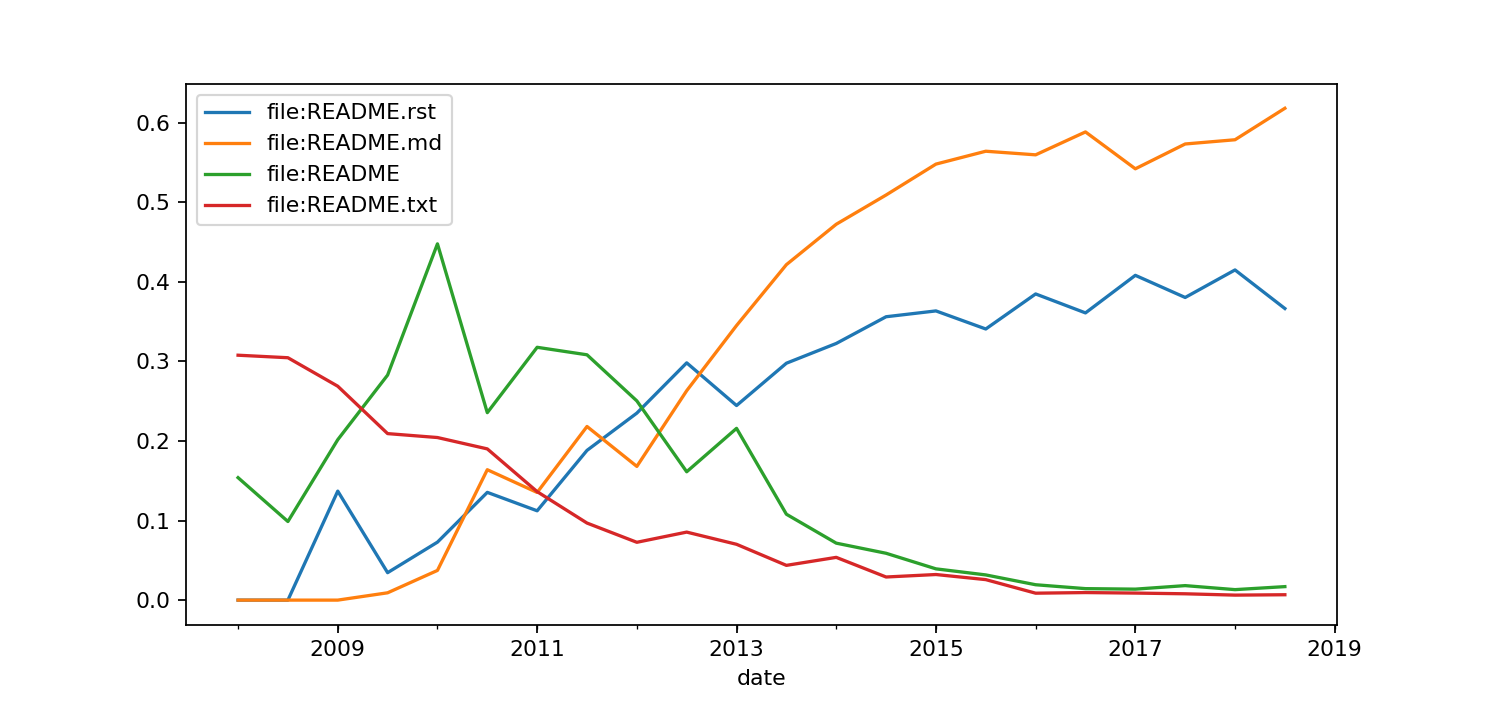

In [4]:
readmes = (stats['file:README.rst', 'file:README.md', 'file:README', 'file:README.txt'].mean().plot())

# Requirements

Nothing really interesting here, we see the rise of Pipfile, but still can't say much about it.

<IPython.core.display.Javascript object>


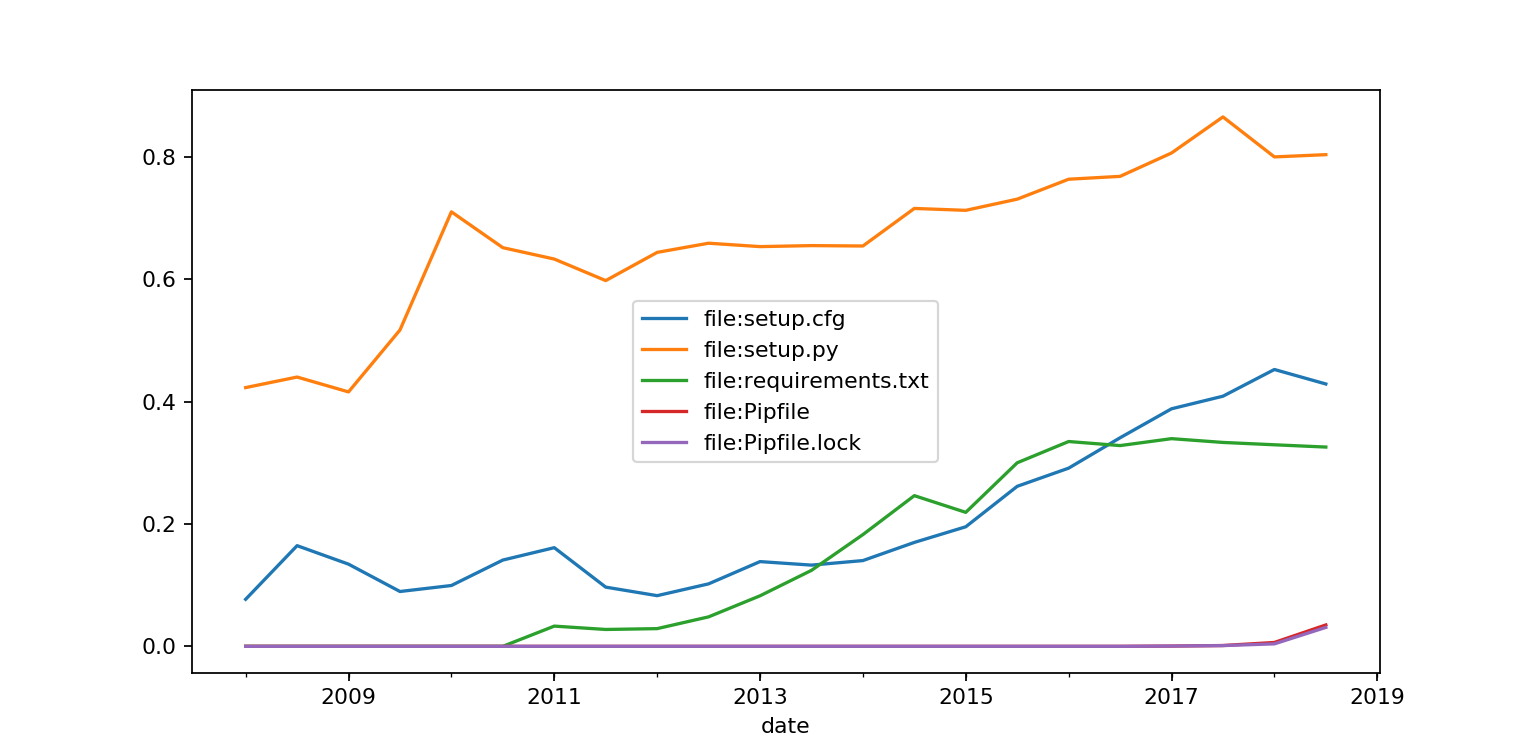

In [5]:
setups = stats['file:setup.cfg', 'file:setup.py', 'file:requirements.txt', 'file:Pipfile', 'file:Pipfile.lock'].mean().plot()

# Tests

Sorry nose.

<IPython.core.display.Javascript object>


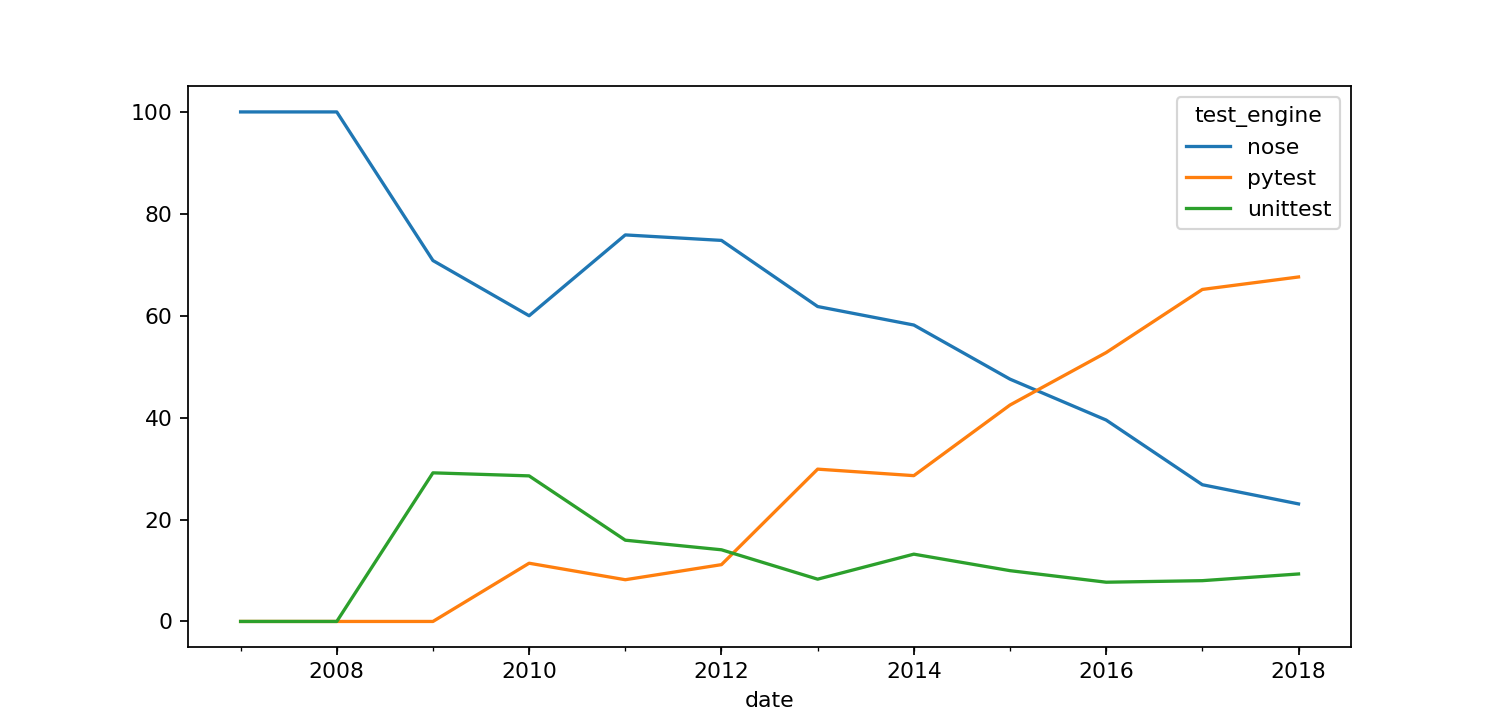

In [12]:
tests = (raw_data.groupby('test_engine')
         .resample('Y')['test_engine']
         .size()
         .unstack()
         .T
         .fillna(0)
         .apply(lambda line: 100 * line / float(line.sum()), axis=1)
         .plot())

<IPython.core.display.Javascript object>


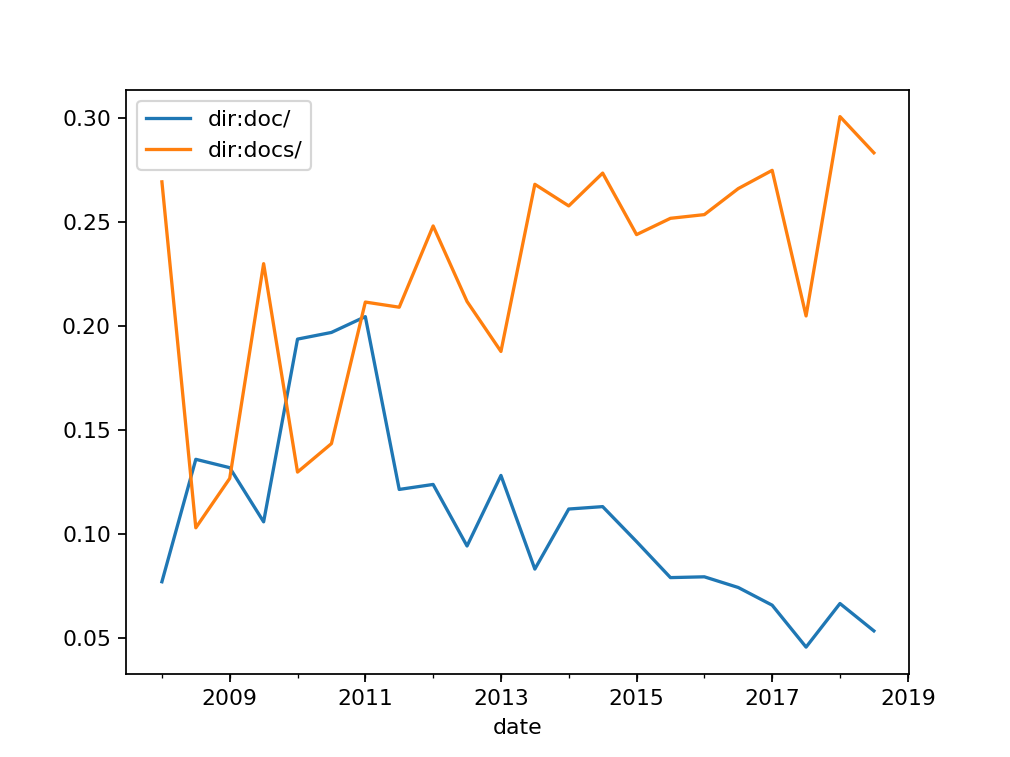

In [13]:
docs = stats['dir:doc/', 'dir:docs/'].mean().plot()

<IPython.core.display.Javascript object>


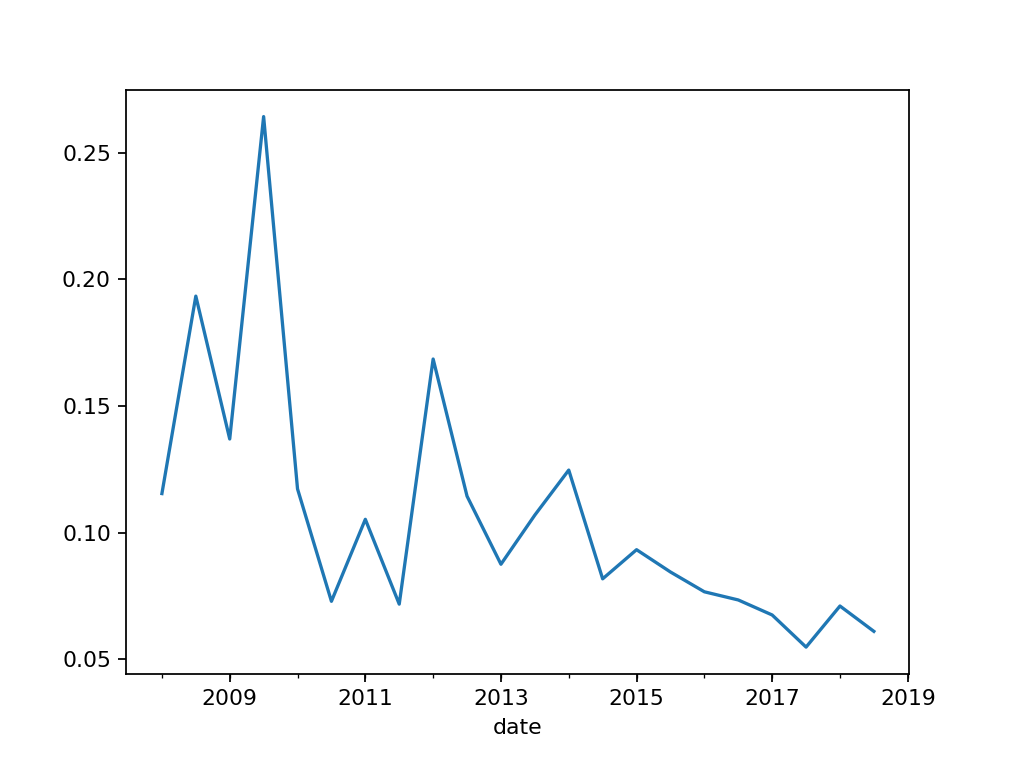

In [14]:
has_src = stats['dir:src/'].mean().plot()

<IPython.core.display.Javascript object>


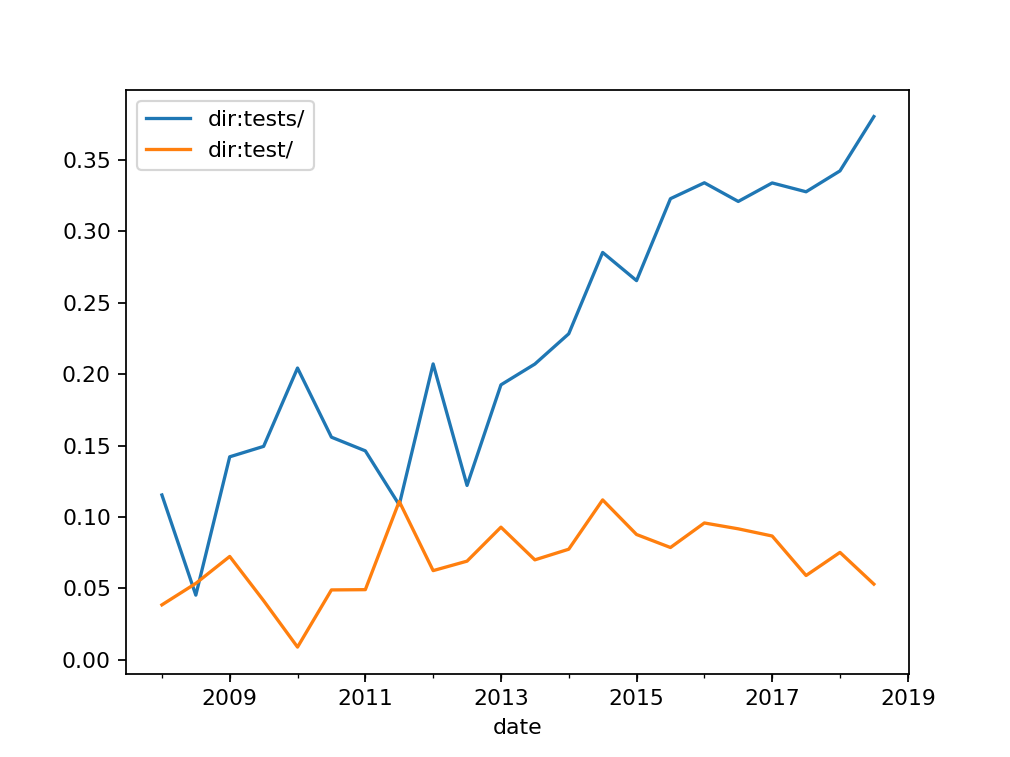

In [15]:
has_tests = stats['dir:tests/', 'dir:test/', ].mean().plot() 

In [16]:
shebangs = raw_data.loc['2008-01-01':,raw_data.columns.map(lambda col: col.startswith('shebang:'))].sum()

In [17]:
top_shebangs = shebangs.sort_values().tail(4).index

<IPython.core.display.Javascript object>


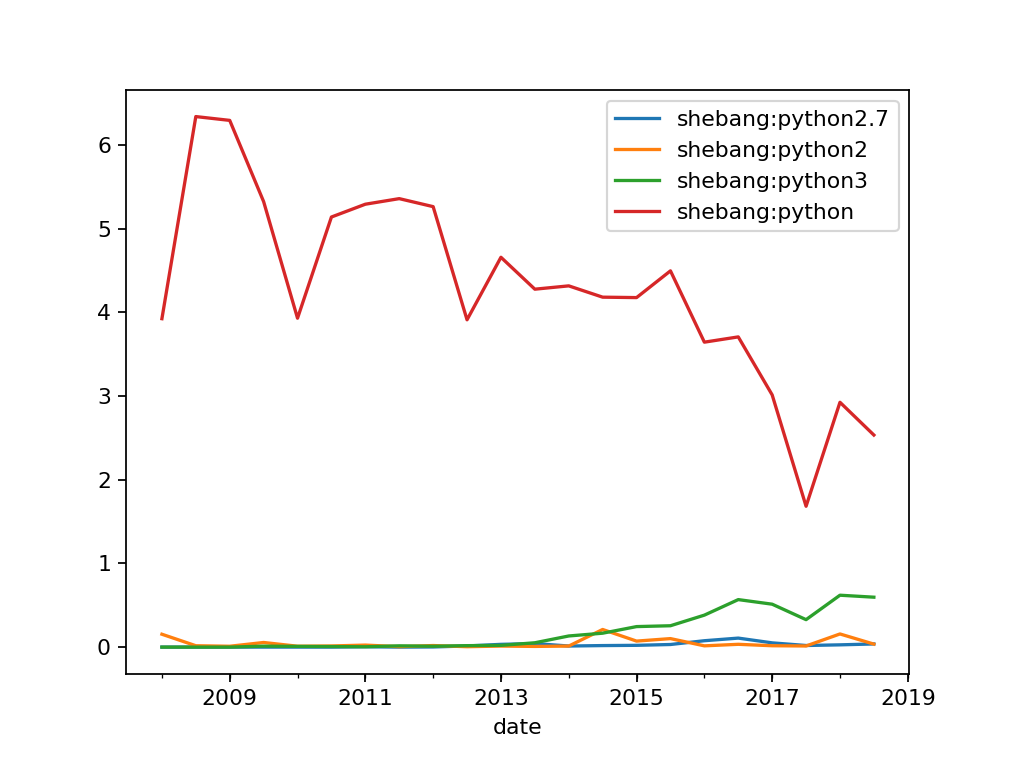

In [18]:
shebangs_plot = raw_data.loc['2008-01-01':, top_shebangs].fillna(value=0).resample('6M').mean().plot()

<IPython.core.display.Javascript object>


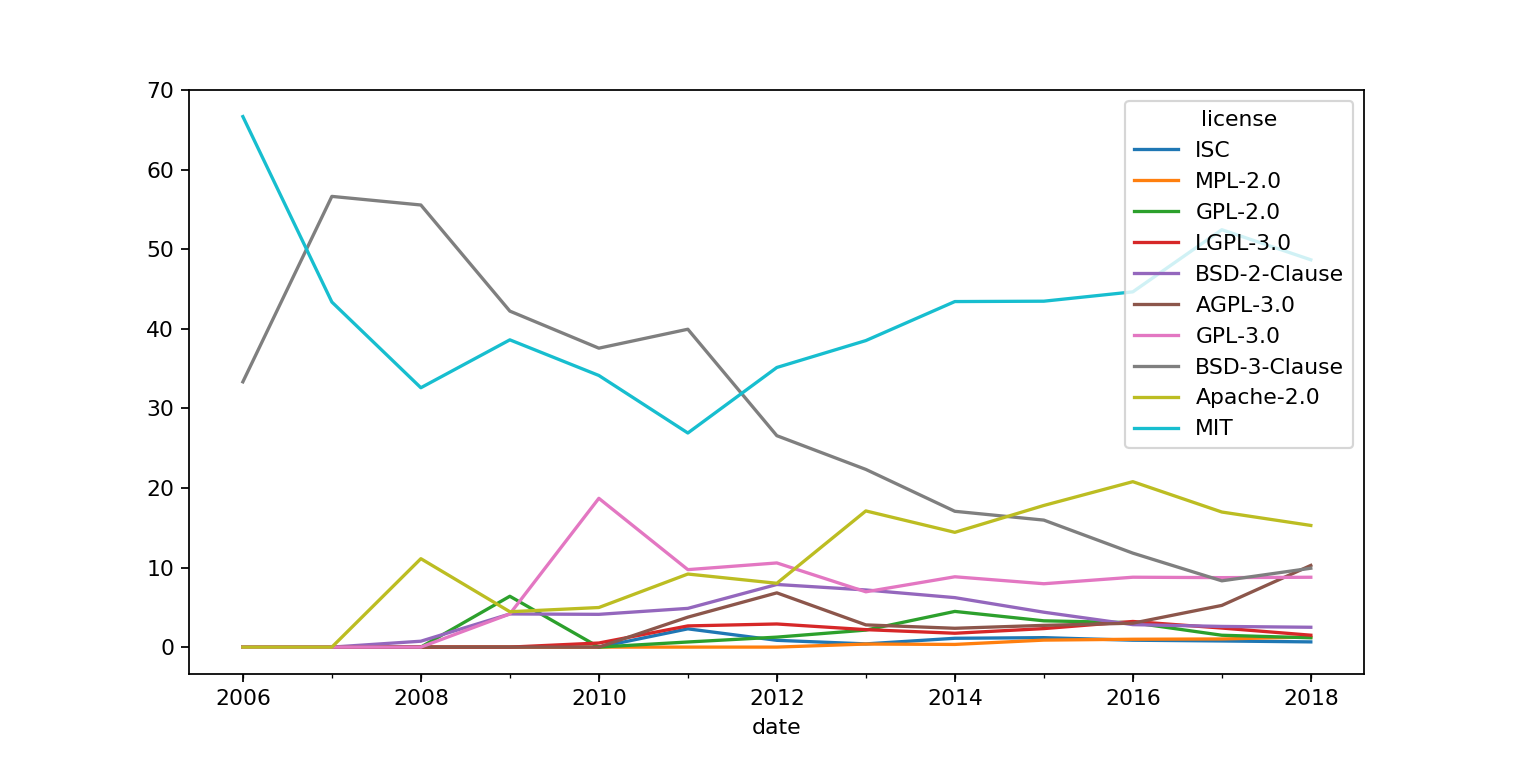

In [19]:
top_licenses = raw_data.groupby('license').size().sort_values().tail(10)
licenses = (raw_data.groupby('license')
            .resample('Y')['license']
            .size()
            .unstack()
            .T
            .fillna(0)
            .loc[:, list(top_licenses.index)]
            .apply(lambda line: 100 * line / float(line.sum()), axis=1)
            .plot())

<IPython.core.display.Javascript object>


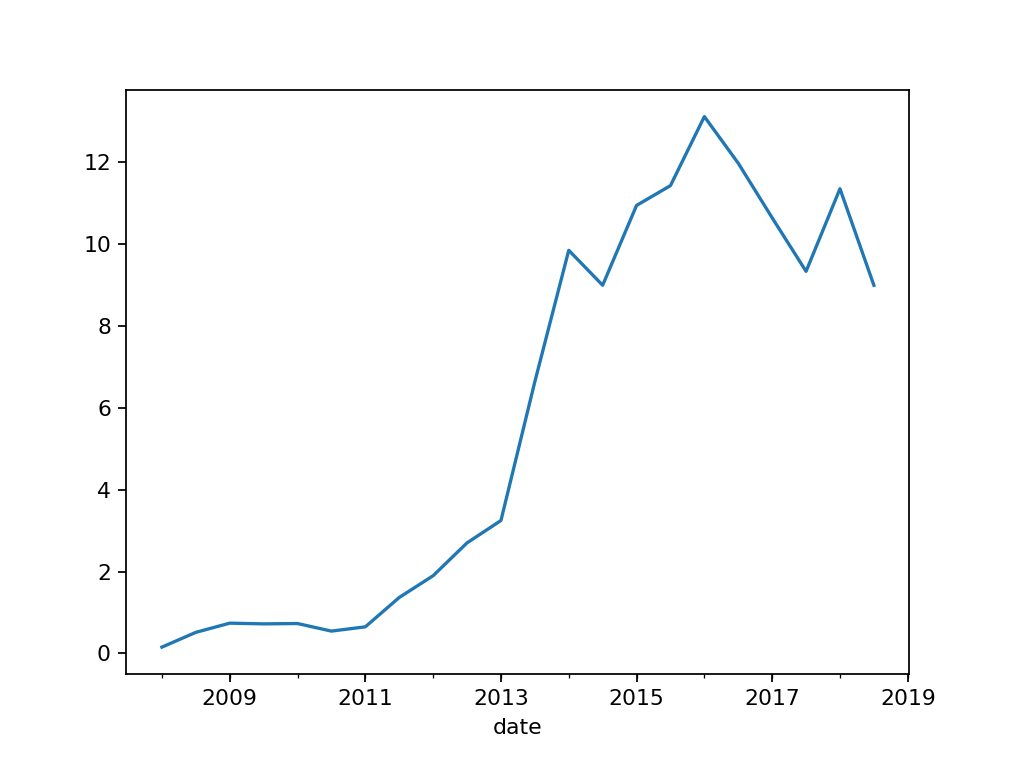

In [20]:
dunder_future = stats['dunder_future_pct'].mean().plot()